# Codes to run to begin

In [1]:
import pymongo as pm
import gridfs
import cPickle

conn = pm.MongoClient(port=29101)

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pylab

from scipy import misc
import os
import time

In [3]:
def show_train_learnrate(curr_expid, conn = conn, dbname = 'combinet-test', colname = 'combinet.files', start_N = 50, 
                        do_conv = False, conv_len = 100, new_figure = True):
    train_vec = np.concatenate([[(_r['loss'], _r['learning_rate']) for _r in r['train_results']] 
                for r in conn[dbname][colname].find(
                {'exp_id': curr_expid, 'train_results': {'$exists': True}})])
    
    #print(train_vec.shape)
    _N = start_N
    if new_figure:
        fig = plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    inter_list = train_vec[_N:, 0]
    if do_conv:
        conv_list = np.ones([conv_len])/conv_len
        inter_list = np.convolve(inter_list, conv_list, mode='valid')
    plt.plot(inter_list)
    plt.title('Training loss')
    plt.subplot(1, 2, 2)
    plt.plot(train_vec[_N:, 1])
    plt.title('Learning Rate')



    #plt.gca().set_xscale('log')


In [4]:
vis_big_dict = {}

In [5]:
def show_val(curr_expid, conn = conn, key = 'loss', dbname = 'combinet-test', colname = 'combinet.files', new_figure = True):
    test_vec = [r['validation_results']['topn'][key] for r in conn[dbname][colname].find({'exp_id': curr_expid,
                                                                                        'validation_results': {'$exists': True}})]
    _N = 0
    #print(test_vec)
    if new_figure:
        plt.figure()
    plt.plot(test_vec[_N:])
    #plt.gca().set_xscale('log')
    plt.title('Validation Performance')    

In [6]:
def show_status(curr_expid, conn = conn, new_figure = True, dbname = 'combinet-test', colname = 'combinet.files'):
    show_train_learnrate(curr_expid, conn = conn, do_conv=True, new_figure = new_figure, dbname = dbname, colname = colname)
    show_val(curr_expid, conn = conn, new_figure = new_figure, dbname = dbname, colname = colname)

In [7]:
def show_result_from_mongodb(exp_id_now, indx_rec, which_save = 0, which_exam = 0, dbname = 'normalnet-test', colname = 'normalnet.files',
                             conn = conn, cache_flag = False, big_dict = vis_big_dict, inv_norm = False):
    r = conn[dbname][colname].find({'exp_id': exp_id_now, 'validation_results': {'$exists': True}})
    idval = r[indx_rec]['_id']
    coll = conn[dbname][colname]
    fn = coll.find({'item_for': idval})[0]['filename']

    if fn in big_dict:
        saved_data = big_dict[fn]
    else:
        fs = gridfs.GridFS(coll.database, 'normalnet')
        fh = fs.get_last_version(fn)
        saved_data = cPickle.loads(fh.read())
        fh.close()

        if cache_flag:
            big_dict[fn] = saved_data
    
    output_now = saved_data['validation_results']['feats']['outputs_fea'][which_save][which_exam]
    normal_now = saved_data['validation_results']['feats']['normals_fea'][which_save][which_exam]
    image_now = saved_data['validation_results']['feats']['images_fea'][which_save][which_exam]
    
    if inv_norm:
        orig_norm = np.linalg.norm(normal_now, axis = 2)
        new_norm = np.linalg.norm(output_now, axis = 2)
        for im_indx1 in xrange(output_now.shape[0]):
            for im_indx2 in xrange(output_now.shape[1]):
                output_now[im_indx1][im_indx2] = output_now[im_indx1][im_indx2]/new_norm[im_indx1][im_indx2]*orig_norm[im_indx1][im_indx2]                

    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.imshow(output_now)
    ax1.axis('off')
    ax2.imshow(normal_now)
    ax2.axis('off')
    ax3.imshow(image_now)
    plt.gcf().set_size_inches(10.5, 4.5)
    ax3.axis('off')

# Network predicting normals on both datasets

In [6]:
curr_expid = 'combinet_test'

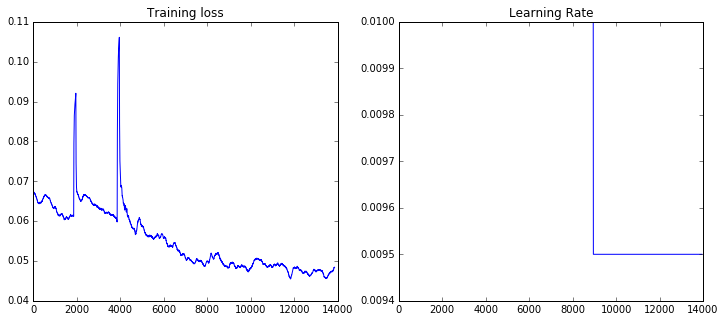

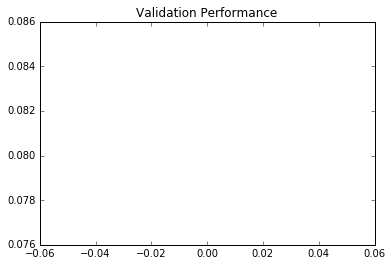

In [20]:
show_status(curr_expid)

# Normalnet alone testing

python train_normalnet.py --nport 29101 --pathconfig normals_config_fcnvgg16.cfg --expId normalnet_t --gpu 0 --cacheDirPrefix /mnt/fs0/chengxuz/ --namefunc normal_vgg16_tfutils

on node7

python train_normalnet.py --nport 29101 --pathconfig normals_config_fcnvgg16.cfg --expId normalnet_s --gpu 0 --cacheDirPrefix /mnt/fs0/chengxuz/ --namefunc normal_vgg16_tfutils --whichdataset 1
 
 on node8

python train_normalnet.py --nport 29101 --pathconfig normals_config_fcnvgg16.cfg --expId normalnet_s_ld --gpu 1 --cacheDirPrefix /mnt/fs0/chengxuz/ --namefunc normal_vgg16_tfutils --whichdataset 1 --whichloss 1

on node12, tmux

In [24]:
curr_expid = 'normalnet_s'

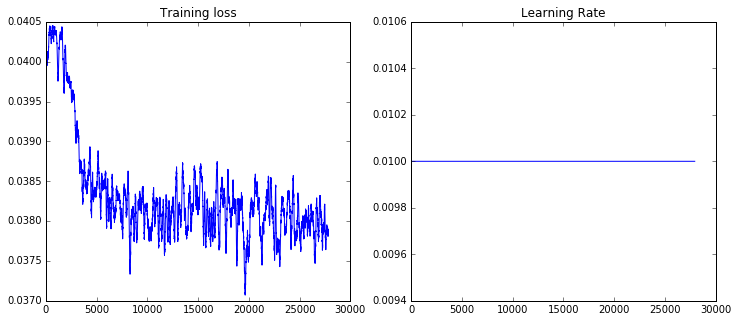

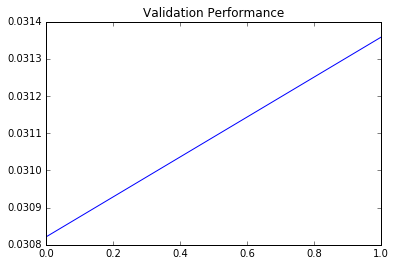

In [34]:
show_status(curr_expid, dbname = 'normalnet-test', colname = 'normalnet.files')

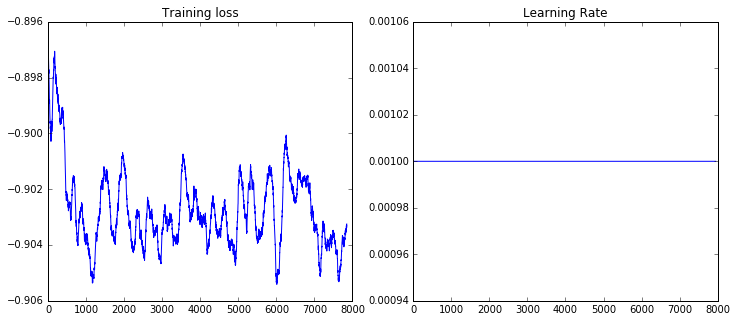

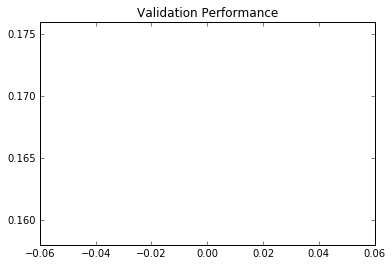

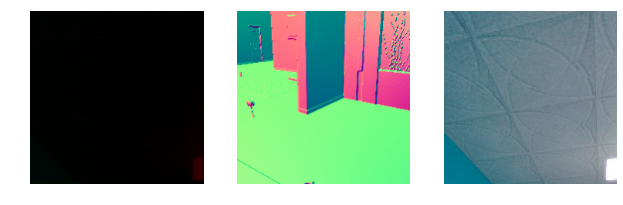

In [74]:
curr_expid = 'normalnet_s_ld'
#curr_expid = 'normalnet_t'
show_status(curr_expid, dbname = 'normalnet-test', colname = 'normalnet.files')
show_result_from_mongodb(curr_expid, 0, 1, 1)

In [31]:
17*1000*300/32

159375

In [29]:
300

300

In [30]:
17000/50

340

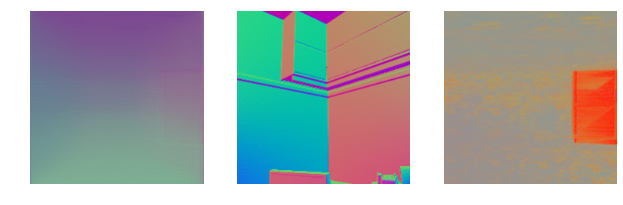

In [52]:
show_result_from_mongodb(curr_expid, 1, 0, 2)

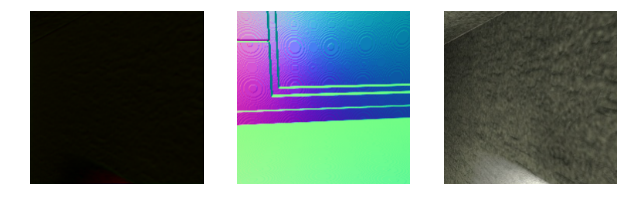

In [92]:
curr_expid = 'normalnet_s_ld_2'
show_result_from_mongodb(curr_expid, 0, 2, 4)

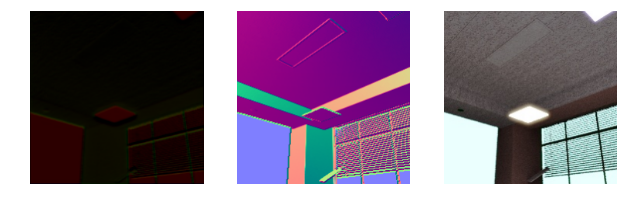

In [99]:
curr_expid = 'normalnet_s_ld_3'
show_result_from_mongodb(curr_expid, 0, 0, 0)

ValueError: need at least one array to concatenate

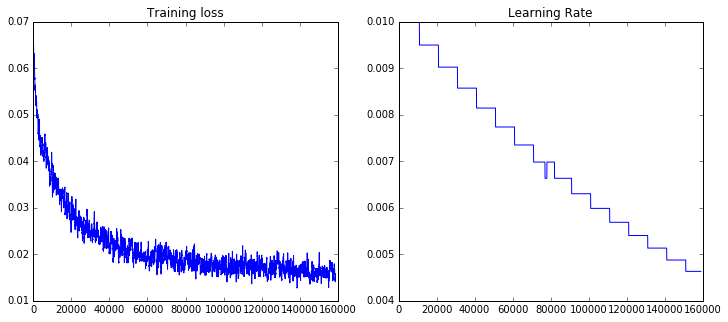

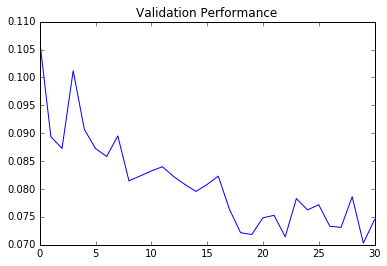

In [10]:
curr_expid = 'combinet_test_3'
show_status(curr_expid)